In [63]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


### PARTIE 1

In [64]:
A0 = 100    
alpha = 0.1 
sigma = 0.2 
B_barre = 75   
T = 1       
rho = 0.1  
n = 100

### PARTIE 2

In [65]:
# Distance au défaut (dd)
dd = (np.log(A0) - np.log(B_barre) + (alpha - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

# Proba de défaut (PD)
PD = norm.cdf(-dd)

print(f"Distance au défaut : {dd:.2f}")
print(f"Probabilité de défaut : {PD:.4f}, soit {PD*100:.2f}%")

Distance au défaut : 1.84
Probabilité de défaut : 0.0330, soit 3.30%


### PARTIE 3

In [66]:
# Générateur de nombres aléatoires
rng = np.random.default_rng()

# Nombre de trajectoires simulées
M = 10000

# Simuler F (choc commun) 
F = rng.standard_normal(M) 

# Simuler n valeurs de z̃ (chocs indépendants) 
z_tilde = rng.standard_normal((M, n)) 

# Calculer valeurs de z_i
z_i = np.sqrt(rho) * F[:, None] + np.sqrt(1 - rho) * z_tilde

# Simuler n valeurs de A (i,T)
A_T = A0 * np.exp((alpha - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z_i)

# Calculer n valeurs de L (défaut ou non)
L_i = (A_T < B_barre).astype(int)

# Calculer proportion défauts 
L = L_i.mean(axis=1)  

mean_L = L.mean()

print(f"Moyenne VALEURS SIMULÉES : {mean_L:.4f}")
print(f"Probabilité de défaut THÉORIQUE : {PD:.4f}")

Moyenne VALEURS SIMULÉES : 0.0328
Probabilité de défaut THÉORIQUE : 0.0330


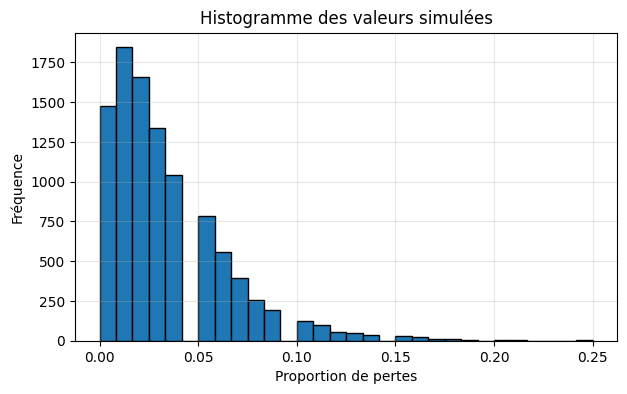

In [67]:
# Histogramme des valeurs simulées
plt.figure(figsize=(7, 4))
plt.hist(L, bins=30, edgecolor='black')
plt.title("Histogramme des valeurs simulées")
plt.xlabel("Proportion de pertes")
plt.ylabel("Fréquence")
plt.grid(alpha=0.3)
plt.show()

/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_1803/2448637568.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


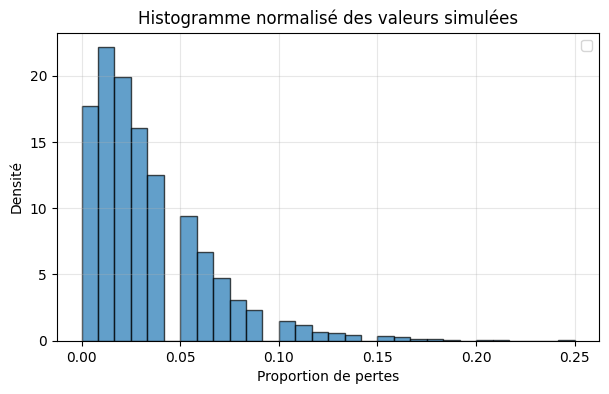

In [68]:
# Histogramme NORMALISÉ des valeurs simulées
plt.figure(figsize=(7, 4))
plt.hist(L, bins=30, density=True, edgecolor='black', alpha=0.7)
plt.title("Histogramme normalisé des valeurs simulées")
plt.xlabel("Proportion de pertes")
plt.ylabel("Densité")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### PARTIE 4

In [69]:
# Définition fonction densité proportion pertes
def fonction_densité(x, PD, rho):
    x = np.asarray(x)
    # Éviter valeurs exactes 0 et 1
    x_clipped = np.clip(x, 1e-10, 1 - 1e-10)
    
    terme1 = np.sqrt((1 - rho) / rho)
    
    # Termes dans l'exponentielle
    a = -1 / (2 * rho)
    b = np.sqrt(1 - rho)
    c = norm.ppf(x_clipped)
    d = norm.ppf(PD)

    terme_exp1 = a * (b * c - d)**2
    terme_exp2 = 1/2 * c**2
    
    densite = terme1 * np.exp(terme_exp1 + terme_exp2)
    
    return densite

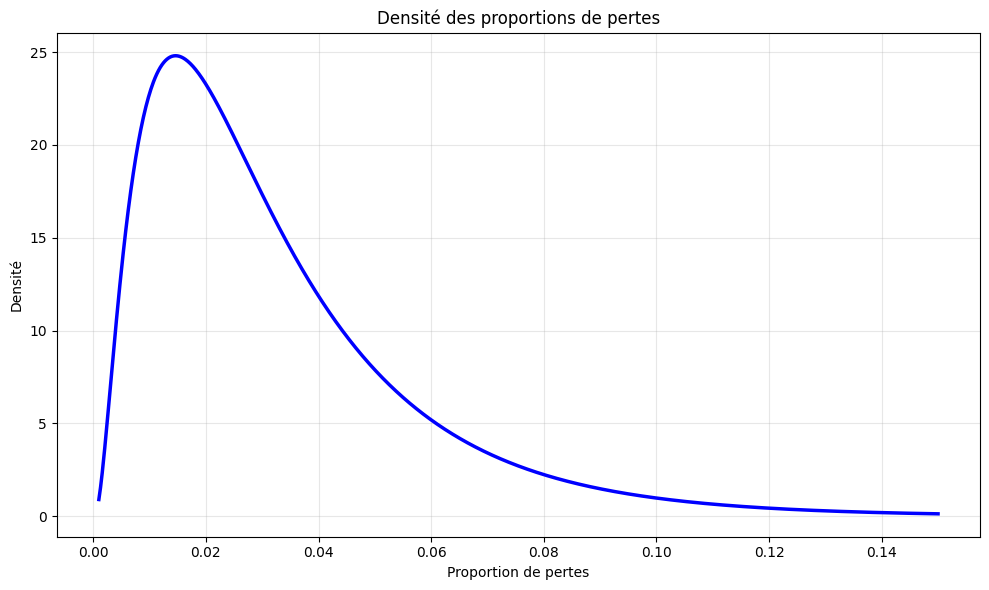

In [70]:
# Graphique densité des proportions de pertes 
x_grid = np.linspace(0.001, 0.15, 1000)
f_vals = fonction_densité(x_grid, PD, rho)

plt.figure(figsize=(10, 6))

# Courbe de densité théorique
plt.plot(x_grid, f_vals, 'b-', linewidth=2.5)

plt.title("Densité des proportions de pertes")
plt.xlabel("Proportion de pertes")
plt.ylabel("Densité")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### PARTIE 5

In [71]:
# Définition fonction densité cumulative proportions pertes 
def fonction_cumulative(x, PD, rho):
    x = np.asarray(x)
    # Éviter valeurs exactes 0 et 1
    x_clipped = np.clip(x, 1e-10, 1 - 1e-10)
    
    N_inv_x = norm.ppf(x_clipped)
    
    # Définition des termes
    e = np.sqrt(1 - rho)
    f = N_inv_x
    g = norm.ppf(PD)
    h = np.sqrt(rho)

    cumulative = norm.cdf((e * f - g) / h)
    
    return cumulative

In [72]:
# Calcul de Pr(L < 0.0823)
x = 0.0823
prob_cumulative = fonction_cumulative(x_valeur, PD, rho)

print(f"Pr(L < {x}) = {prob_cumulative:.4f}, soit {prob_cumulative*100:.2f}%")

Pr(L < 0.0823) = 0.9499, soit 94.99%


In [73]:
# Calcul de Pr(L < 0.0823) avec simulations
prob_empirique = np.mean(L < x)

print(f"Pr(L < {x}) ESTIMÉE   : {prob_empirique:.4f}, soit {prob_empirique*100:.2f}%")
print(f"Pr(L < {x}) THÉORIQUE : {prob_cumulative:.4f}, soit {prob_cumulative*100:.2f}%")

Pr(L < 0.0823) ESTIMÉE   : 0.9356, soit 93.56%
Pr(L < 0.0823) THÉORIQUE : 0.9499, soit 94.99%


### PARTIE 6

In [74]:
def VaR(p, PD, rho):
    
    # Définition des termes
    i = np.sqrt(rho)
    j = norm.ppf(1 - p)
    k = norm.ppf(PD)
    l = np.sqrt(1 - rho)

    var = norm.cdf((i * j + k) / l)
    
    return var

In [75]:
# Calcul de la VaR avec probabilité de 5%
p_val = 0.05
var_5 = VaR(p_val, PD, rho)

print("VaR POUR PROBABILITÉ 5% :")
print(f"VaR (p = {p_val*100}%) = {var_5:.4f}, soit {var_5*100:.2f}%")

VaR POUR PROBABILITÉ 5% :
VaR (p = 5.0%) = 0.0823, soit 8.23%


In [76]:
# Calcul de la VaR avec probabilité de 5% par simulations
var_empirique = np.percentile(L, (1 - p_val) * 100)

print("COMPARAISON VaR SIMULATION vs THÉORIQUE :")
print(f"VaR par SIMULATION (p = {p_val*100}%) = {var_empirique:.4f}, soit {var_empirique*100:.2f}%")
print(f"VaR THÉORIQUE (p = {p_val*100}%) = {var_5:.4f}, soit {var_5*100:.2f}%")

COMPARAISON VaR SIMULATION vs THÉORIQUE :
VaR par SIMULATION (p = 5.0%) = 0.0900, soit 9.00%
VaR THÉORIQUE (p = 5.0%) = 0.0823, soit 8.23%


### PARTIE 7

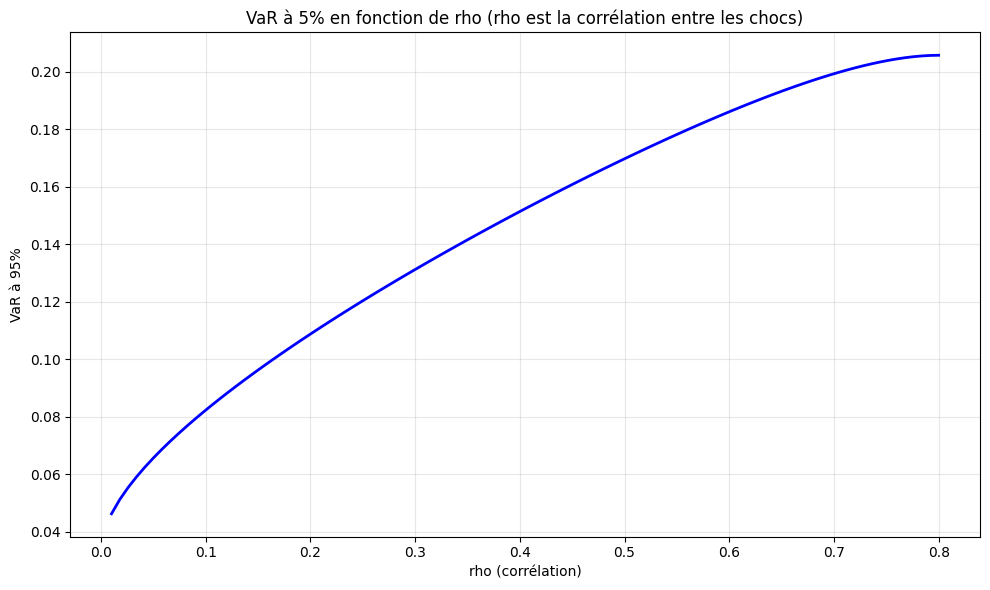

In [77]:
# Graphique de la VaR en fonction de rho
rho_values = np.linspace(0.01, 0.8, 100)
var_values = [VaR(p_val, PD, r) for r in rho_values]

plt.figure(figsize=(10, 6))
plt.plot(rho_values, var_values, 'b-', linewidth=2)
plt.title(f"VaR à {p_val*100:.0f}% en fonction de rho (rho est la corrélation entre les chocs)")
plt.xlabel("rho (corrélation)")
plt.ylabel(f"VaR à {(1-p_val)*100:.0f}%")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()